# Selección de features para el S&P 500

## Procedimientos

- Cargar features y variable de clase
- Calcular filtrado de features:
    - Filtrar features con mayor poder predictivo con la variable de clase
    - Filtrar features más independientes entre sí
    - Reducir espacio de features (PCA)

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import itertools as it
import pickle as pk
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, Imputer
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFdr, SelectFpr, SelectFromModel, RFECV
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier

import pymrmr as mrmr

sns.set(context="notebook", style="ticks", palette="muted", color_codes=True)

In [3]:
X = pd.read_csv("../data/processed/sp500-ml/features-raw.csv", index_col=0, parse_dates=True, header=[0, 1])
Y = pd.read_csv("../data/processed/sp500-ml/target-raw.csv", index_col="Date", parse_dates=True)

X.columns = X.columns.droplevel("Type")

# remove ascient data
X.fillna(method="ffill", inplace=True)
X.dropna(how="all", axis="index", inplace=True)
Y = Y.reindex(index=X.index)
Y.dropna(how="all", axis="index", inplace=True)
X = X.reindex(index=Y.index)
y = Y.Class

In [4]:
# fill NANs using imputer
imp = Imputer()
X_filled = imp.fit_transform(X, y)
# rescale features
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(index=X.index, columns=X.columns, data=scaler.fit_transform(X_filled))
# define columns metadata
icols = arange(X_scaled.columns.size, dtype=int)
ncols = X_scaled.columns.values

In [5]:
# define selectors
selector_names = ["K-best", "Percentile", "Fdr", "Fpr", "fromModel", "Recursive", "mRMR"]
selector_functions = [SelectKBest, SelectPercentile, SelectFdr, SelectFpr, SelectFromModel, RFECV, mrmr.mRMR]
# define selector parameters
score_names = ["Chi square", r"F-statistic", r"Mutual Inf."]
score_functions = [chi2, f_classif, mutual_info_classif]
selector_params = [
    list(it.product(score_functions, range(1, icols.size, 7))),
    list(it.product(score_functions, [5, 10])),
    list(it.product(score_functions, [0.01, 0.05])),
    list(it.product(score_functions, [0.01, 0.05])),
    [ExtraTreesClassifier(criterion="entropy")],
    [ExtraTreesClassifier(criterion="entropy")],
    list(it.product(["MIQ", "MID"], range(1, icols.size, 7)))
]
selector_params_h = [
    list(it.product(score_names, range(1, icols.size, 7))),
    list(it.product(score_names, [5, 10])),
    list(it.product(score_names, [0.01, 0.05])),
    list(it.product(score_names, [0.01, 0.05])),
    ["Decision Tree"],
    ["Decision Tree"],
    list(it.product(["MIQ", "MID"], range(1, icols.size, 7)))
]
param_groups = [
    {"par-{}".format(j+1): pars for j, pars in enumerate(selector_params_h[i])} for i in xrange(len(selector_names))
]
# define tables
selected_features = pd.DataFrame(
    index=pd.Index(data=ncols, name="Feature"),
    columns=pd.MultiIndex.from_tuples(
        tuples=[(selector_names[j], "par-{}".format(i+1)) for j in xrange(len(selector_names))
                for i in xrange(len(selector_params[j]))],
        names=["Selector", "Parameter group"]
    ),
    data=True
)
selected_scores = pd.DataFrame(
    index=pd.Index(data=ncols, name="Feature"),
    columns=pd.MultiIndex.from_tuples(
        tuples=[(selector_names[j], "par-{}".format(i+1)) for j in xrange(len(selector_names))
                for i in xrange(len(selector_params[j]))],
        names=["Selector", "Parameter group"]
    ),
    data=None
)

In [6]:
for i in xrange(len(selector_names)):
    print selector_names[i]
    
    selected = zeros(ncols.size, dtype=bool)
    for j, params in enumerate(selector_params[i]):
        if selector_names[i] in ["K-best", "Percentile", "Fdr", "Fpr"]:
            metric, threshold = params
            selector = selector_functions[i](metric, threshold)
            selector.fit(X_scaled, y)
    
            scores = selector.scores_
            scores /= scores.sum()
            
            if selector_names[i] == "K-best":
                selected[scores.argsort()[-threshold:]] = True
            elif selector_names[i] == "Percentile":
                selected = scores > percentile(scores, q=threshold)
            elif selector_names[i] in ["Fdr", "Fpr"]:
                selected = selector.pvalues_ <= threshold
        elif selector_names[i] == "fromModel":
            estimator = params
            estimator.fit(X_scaled, y)
            model = SelectFromModel(estimator, prefit=True)
            
            scores = estimator.feature_importances_
            scores /= scores.sum()
            
            selected = scores >= scores.mean()
        elif selector_names[i] == "Recursive":
            estimator = params
            rfecv = RFECV(estimator, scoring="accuracy")
            rfecv.fit(X_scaled, y)
            
            scores = rfecv.grid_scores_
            scores /= scores.sum()
            
            selected = rfecv.ranking_ == 1
        else:
            method, threshold = params
            minRedmaxRel = mrmr.mRMR(X_scaled, method, threshold)
            
            scores = zeros(ncols.size, dtype=float)
            scores[[list(ncols).index(col_name) for col_name in minRedmaxRel]] = 1.0
            scores /= scores.sum()
            
            selected = scores > 0.0

        selected_features[selector_names[i], "par-{}".format(j+1)] = selected
        selected_scores[selector_names[i], "par-{}".format(j+1)] = scores

K-best
Percentile
Fdr
Fpr
fromModel
Recursive
mRMR


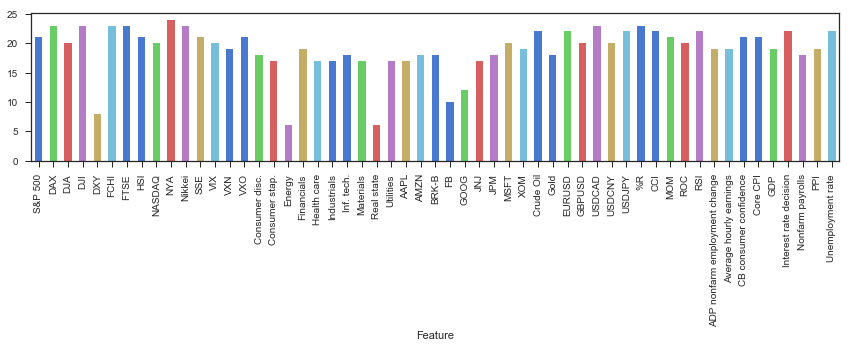

In [7]:
fig, ax = subplots(1, figsize=(12, 5))

selector_groups = selected_features.groupby(axis="columns", level="Selector", sort=False)
for name in selector_groups.groups:
    df = selector_groups.get_group(name)
    summed = df.sum(axis="columns")
    summed.plot(kind="bar", label=name, ax=ax)
# ax.legend(loc=0)
ax.set_xticks(icols)
ax.set_xticklabels(ncols, rotation=90)
fig.tight_layout()
# fig.savefig("../data/img/sp500-features-relevance-all.png", bbox_inches="tight")

In [8]:
for name in selector_names:
    try:
        print name, list(ncols[selected_features[name]["par-3"]])
    except:
        print name, list(ncols[selected_features[name]["par-1"]])

K-best ['DAX', 'DJI', 'FCHI', 'FTSE', 'NYA', 'Nikkei', 'Crude Oil', 'EURUSD', 'USDCAD', 'USDJPY', '%R', 'CCI', 'RSI', 'Interest rate decision', 'Unemployment rate']
Percentile ['S&P 500', 'DAX', 'DJA', 'DJI', 'FCHI', 'FTSE', 'HSI', 'NASDAQ', 'NYA', 'Nikkei', 'SSE', 'VIX', 'VXN', 'VXO', 'Consumer disc.', 'Consumer stap.', 'Financials', 'Health care', 'Industrials', 'Inf. tech.', 'Materials', 'Utilities', 'AAPL', 'AMZN', 'BRK-B', 'FB', 'GOOG', 'JNJ', 'JPM', 'MSFT', 'XOM', 'Crude Oil', 'Gold', 'EURUSD', 'GBPUSD', 'USDCAD', 'USDCNY', 'USDJPY', '%R', 'CCI', 'MOM', 'ROC', 'RSI', 'ADP nonfarm employment change', 'Average hourly earnings', 'CB consumer confidence', 'Core CPI', 'GDP', 'Interest rate decision', 'Nonfarm payrolls', 'PPI', 'Unemployment rate']
Fdr ['S&P 500', 'DAX', 'DJA', 'DJI', 'FCHI', 'FTSE', 'HSI', 'NASDAQ', 'NYA', 'Nikkei', 'SSE', 'VIX', 'VXO', 'Financials', 'AAPL', 'MSFT', 'XOM', 'Crude Oil', 'Gold', 'EURUSD', 'GBPUSD', 'USDCAD', 'USDCNY', 'USDJPY', '%R', 'MOM', 'ROC', 'RSI'